In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
sys.path.append('/Users/scortesg/Documents/risk_certificate')
sys.path.append('/usr0/home/naveenr/projects/risk_certificate')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 
from certificate.utils import get_results_matching_parameters, aggregate_data, aggregate_normalize_data
import seaborn as sns
from scipy.stats import beta as beta_function
import matplotlib.colors as mcolors
from matplotlib.patches import Patch


In [20]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [21]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [21]:
colors_by_method = {}
non_adaptive_methods = ['','random','k_1','one_stage','fixed_k']
our_methods = ['sample_split','sample_split_total','prior']
adaptive_methods = ['two_stage_thompson','two_stage_successive_elimination','successive_elimination','ucb']

greys = plt.cm.Greys(np.linspace(0.2, 1, len(non_adaptive_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 0.4, len(our_methods)))
wistia = plt.cm.coolwarm(np.linspace(0.6, 0.9, len(adaptive_methods)))

for i,m in enumerate(non_adaptive_methods):
    colors_by_method[m] = greys[i]

for i,m in enumerate(our_methods):
    colors_by_method[m] = vidris[i]

for i,m in enumerate(adaptive_methods):
    colors_by_method[m] = wistia[i]

colors_by_method['omniscient'] = np.array([0.9,0.05,0.05,1.0])
colors_by_method['median_effect'] = np.array([0.2, 0.6, 0.2, 1.0])

KeyboardInterrupt: 

In [ ]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(non_adaptive_methods+our_methods+['omniscient']+adaptive_methods):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]

## AISTATS Plots

In [ ]:
results = get_results_matching_parameters(dataset,"",baseline_params)

random 1.0675912857337213
k_1 1.0208510858287196
one_stage 1.0712168448256776
sample_split 1.0
omniscient 0.9802015571937577
random 1.0684624402290657
k_1 1.0324945097321288
one_stage 1.0571696961294488
sample_split 1.0
omniscient 0.9896588482048236
random 1.060241210838434
k_1 1.0090541521650516
one_stage 1.0132124665387934
sample_split 1.0
omniscient 0.9875981460855234


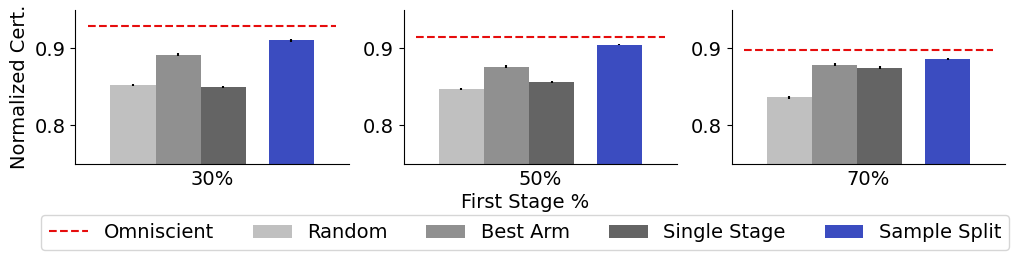

In [100]:
fig, axs = plt.subplots(1,3, figsize=(12, 2))
method_names = ['random','k_1','one_stage','sample_split','omniscient']#,'sample_split_total', 'successive_elimination','ucb','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Omniscient"]#,"Sample Split All Data", "Successive Elimination","UCB","Omniscient"]
width = 0.1

baseline_params = {'sample_size': 500, 'number_arms': 10}
dataset = "baseline"
first_stage_sizes = [150,250,350]
first_stage_percent = ["30%","50%","70%"]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'sample_split' or method_names[i] == 'successive_elimination':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(first_stage_sizes)):
    baseline_params['first_stage_size'] = first_stage_sizes[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random']['certificate'])
    results = aggregate_normalize_data(results,normalized='max')
    for k,m in enumerate(method_names):
        print(m,results['sample_split'][0]/results[m][0])

        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)
        
    
        
        if m == 'omniscient':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.75,0.95])
        axs[i].set_xlabel(first_stage_percent[i],fontsize=14)
        axs[i].set_yticks([0.8,0.9])

axs[0].set_ylabel("Normalized Cert.",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=5,bbox_to_anchor=(0.5,-0.1),fontsize=14)

fig.supxlabel("First Stage %",fontsize=14,x=0.5,y=-0.13)
fig.savefig("../../results/figures/non_adaptive.pdf",dpi=300, bbox_inches='tight')


one_stage 1.0712168448256776
sample_split 1.0
two_stage_successive_elimination 1.0616725655056456
two_stage_thompson 0.9904343427115226
successive_elimination 1.0464996716758739
ucb 0.9702378917784809
omniscient 0.9802015571937577
one_stage 1.0571696961294488
sample_split 1.0
two_stage_successive_elimination 1.0841913096290483
two_stage_thompson 0.9876362911964356
successive_elimination 1.0402108659045899
ucb 0.9644073714080699
omniscient 0.9896588482048236
one_stage 1.0132124665387934
sample_split 1.0
two_stage_successive_elimination 1.0813362297631122
two_stage_thompson 0.9968011702477433
successive_elimination 1.0192832842797188
ucb 0.9450048496249324
omniscient 0.9875981460855234


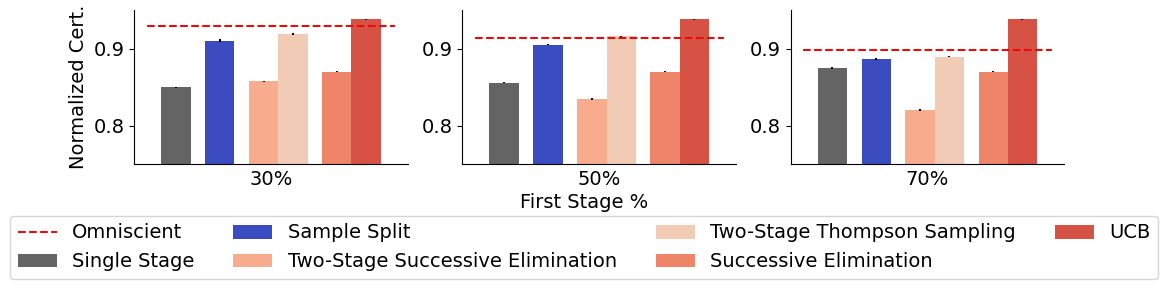

In [128]:
fig, axs = plt.subplots(1,3, figsize=(12, 2))
method_names = ['one_stage','sample_split', 'two_stage_successive_elimination','two_stage_thompson','successive_elimination','ucb','omniscient']
nice_names = ["Single Stage","Sample Split","Two-Stage Successive Elimination","Two-Stage Thompson Sampling","Successive Elimination","UCB","Omniscient"]
width = 0.1

baseline_params = {'sample_size': 500, 'number_arms': 10}
dataset = "baseline"
first_stage_sizes = [150,250,350]
first_stage_percent = ["30%","50%","70%"]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == "sample_split" or method_names[i] == 'two_stage_successive_elimination' or method_names[i] == 'successive_elimination':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(first_stage_sizes)):
    baseline_params['first_stage_size'] = first_stage_sizes[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random']['certificate'])
    results = aggregate_normalize_data(results,normalized='max')
    for k,m in enumerate(method_names):
        print(m,results['sample_split'][0]/results[m][0])
        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)
        
    
        
        if m == 'omniscient':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.75,0.95])
        axs[i].set_xlabel(first_stage_percent[i],fontsize=14)
        axs[i].set_yticks([0.8,0.9])

axs[0].set_ylabel("Normalized Cert.",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.1),fontsize=14)

fig.supxlabel("First Stage %",fontsize=14,x=0.5,y=-0.13)
fig.savefig("../../results/figures/adaptive.pdf",dpi=300, bbox_inches='tight')


In [ ]:
plt.figure(figsize=(5,3))
dataset = "baseline"
sample_size = 500*200
fs = 50*200
temp_params = {'number_arms': 10, 'sample_size': 500, 'first_stage_size': 250}
results = get_results_matching_parameters(dataset,"",temp_params)
print(results)
results = aggregate_normalize_data(results,baseline='one_stage')

value_by_k = [results['k_{}'.format(i)][0] for i in range(1,temp_params['number_arms']+1)]
plt.plot(list(range(1,temp_params['number_arms']+1)),value_by_k,label='Fixed K',color=colors_by_method['fixed_k'])
plt.plot(list(range(1,temp_params['number_arms']+1)),[results['omniscient'][0] for i in range(0,temp_params['number_arms'])],'--',label='Omniscent',color=colors_by_method['omniscient'])
plt.plot(list(range(1,temp_params['number_arms']+1)),[results['sample_split'][0] for i in range(0,temp_params['number_arms'])],'--',label='Sample Split',color=colors_by_method['sample_split'])
plt.legend(loc='upper right',bbox_to_anchor=(1,0.9))
plt.xlabel('k')
plt.ylabel('Certificate')
plt.savefig("../../results/figures/fixed_k.pdf",dpi=300, bbox_inches='tight')

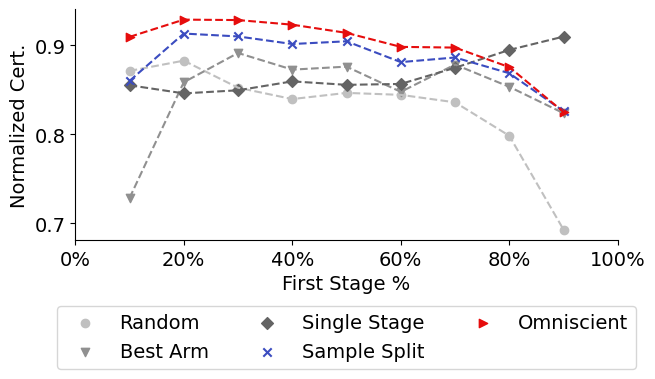

In [53]:
plt.figure(figsize=(7,3))
method_names = ['random','k_1','one_stage','sample_split','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Omniscient"]

first_stage_percents = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
first_stage_strs = ["0%","20%","40%","60%","80%","100%"]
baseline_params = {}

plots_by_method = {}
for m in method_names:
    plots_by_method[m] = []

for first_stage_percent in first_stage_percents:
    baseline_params['first_stage_size'] = 500*first_stage_percent
    baseline_params['sample_size'] = 500
    baseline_params['number_arms'] = 10
    dataset = "baseline"
    results = get_results_matching_parameters(dataset,"",baseline_params)
    results = aggregate_normalize_data(results,normalized="max")
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}'.format(method_name)][0])

for i,m in enumerate(method_names):
    zipped_values = zip(first_stage_percents,plots_by_method[m])
    zipped_values = [i for i in zipped_values]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    plt.plot(x, y,'--', color=colors_by_method[m])

# plt.ylim([0.6,0.9])
plt.xticks([0,0.2,0.4,0.6,0.8,1.0],first_stage_strs)
plt.legend(fontsize=14,bbox_to_anchor=(0.5,-0.6),ncol=3,loc='lower center')
plt.ylabel("Normalized Cert.")
plt.xlabel("First Stage %")
plt.savefig("../../results/figures/first_stage_percent.pdf",dpi=300, bbox_inches='tight')



random 100 TtestResult(statistic=18.295401774698167, pvalue=1.1937762701178538e-67, df=1499)
random 100 1.1528275149647973
k_1 100 TtestResult(statistic=16.136369851996154, pvalue=3.9174791736187534e-54, df=1499)
k_1 100 1.132668665515587
one_stage 100 TtestResult(statistic=6.734054907405958, pvalue=2.3436885749781743e-11, df=1499)
one_stage 100 1.0654063079534999
sample_split 100 TtestResult(statistic=nan, pvalue=nan, df=1499)
sample_split 100 1.0
omniscient 100 TtestResult(statistic=-18.911566352829695, pvalue=1.0495982040894304e-71, df=1499)
omniscient 100 0.9484350855321598
random 200 TtestResult(statistic=27.899711779346784, pvalue=2.5701376051941703e-138, df=1499)
random 200 1.0796981705393522
k_1 200 TtestResult(statistic=15.070859199933027, pvalue=6.746234469373789e-48, df=1499)
k_1 200 1.0634326397701122
one_stage 200 TtestResult(statistic=21.295999725900533, pvalue=3.9091697944491667e-88, df=1499)
one_stage 200 1.0619487082079944
sample_split 200 TtestResult(statistic=nan, pv

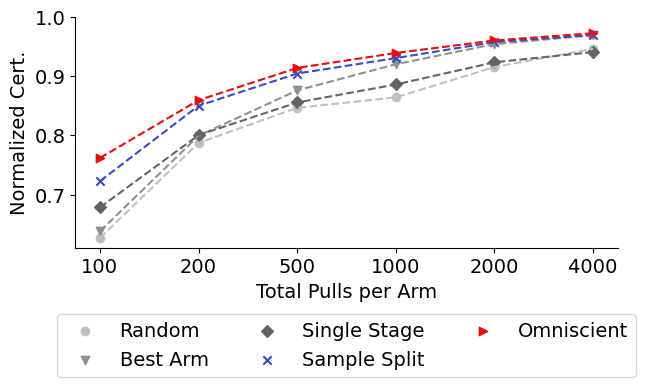

In [127]:
plt.figure(figsize=(7,3))
method_names = ['random','k_1','one_stage','sample_split','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Omniscient"]

total_stage_values = [100,200,500,1000,2000,4000]
baseline_params = {}

plots_by_method = {}
for m in method_names:
    plots_by_method[m] = []

for total_stage_value in total_stage_values:
    baseline_params['first_stage_size'] = total_stage_value//20*10
    baseline_params['sample_size'] = total_stage_value
    dataset = "baseline"
    all_results = get_results_matching_parameters(dataset,"",baseline_params)
    results = aggregate_normalize_data(all_results,baseline='one_stage')
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}'.format(method_name)][0])
        results_method = [i[method_name]['certificate'] for i in all_results if method_name in i]
        results_ours = [i['sample_split']['certificate'] for i in all_results if method_name in i]
        print(method_name,total_stage_value,stats.ttest_rel(np.array(results_ours).flatten(),np.array(results_method).flatten()))
        print(method_name,total_stage_value,results['sample_split'][0]/results[method_name][0])

for i,m in enumerate(method_names):
    zipped_values = zip(list(range(len(total_stage_values))),plots_by_method[m])
    zipped_values = [i for i in zipped_values]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    plt.plot(x, y,'--', color=colors_by_method[m])

# plt.ylim([0.6,1])
plt.xticks(list(range(len(total_stage_values))),total_stage_values)
plt.yticks([0.7,0.8,0.9,1.0])
plt.legend(fontsize=14,bbox_to_anchor=(0.5,-0.6),ncol=3,loc='lower center')
plt.ylabel("Normalized Cert.")
plt.xlabel("Total Pulls per Arm")
plt.savefig("../../results/figures/total_pulls.pdf",dpi=300, bbox_inches='tight')



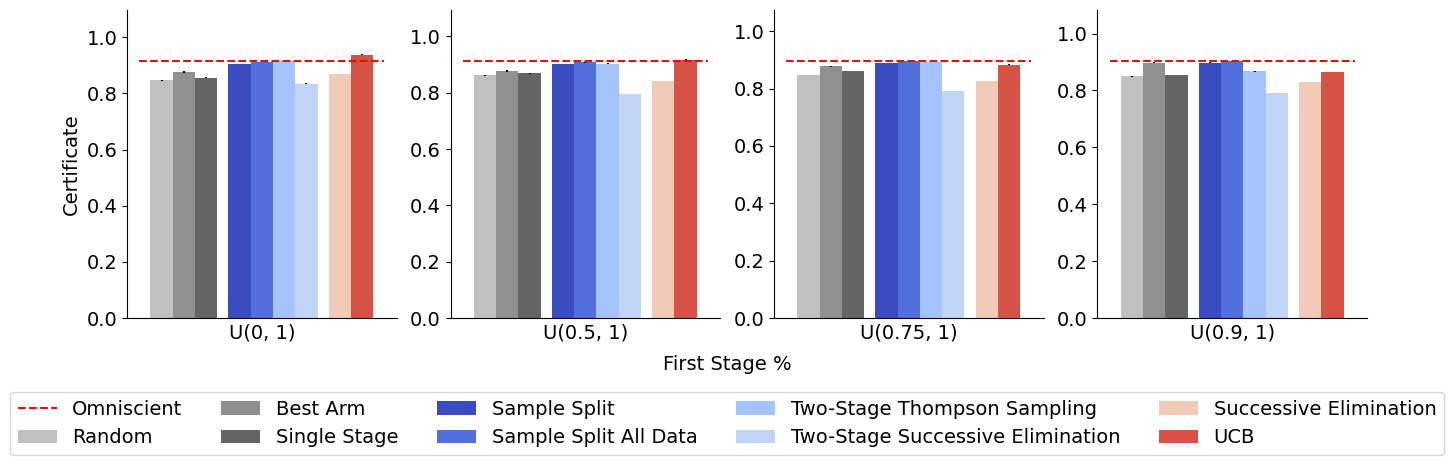

<Figure size 700x400 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))
method_names = ['random','k_1','one_stage','sample_split','sample_split_total','two_stage_thompson','two_stage_successive_elimination','successive_elimination','ucb','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Sample Split All Data","Two-Stage Thompson Sampling","Two-Stage Successive Elimination","Successive Elimination","UCB","Omniscient"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'sample_size': 500, 'number_arms': 10}
dataset = "vary_gaps"
low_high = [(0,1),(0.5,1),(0.75,1),(0.9,1)]
first_stage_percent = ["U"+str(i) for i in low_high]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'sample_split' or method_names[i] == 'successive_elimination':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(low_high)):
    baseline_params['uniform_low'] = low_high[i][0]
    baseline_params['uniform_high'] = low_high[i][1]

    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random']['certificate'])
    results = aggregate_normalize_data(results,baseline='one_stage')
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)

        if m == 'omniscient':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(first_stage_percent[i],fontsize=14)
        

axs[0].set_ylabel("Certificate",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=5,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.supxlabel("First Stage %",fontsize=14,x=0.5,y=-0.03)
fig.savefig("../../results/figures/performance_by_distribution.pdf",dpi=300, bbox_inches='tight')


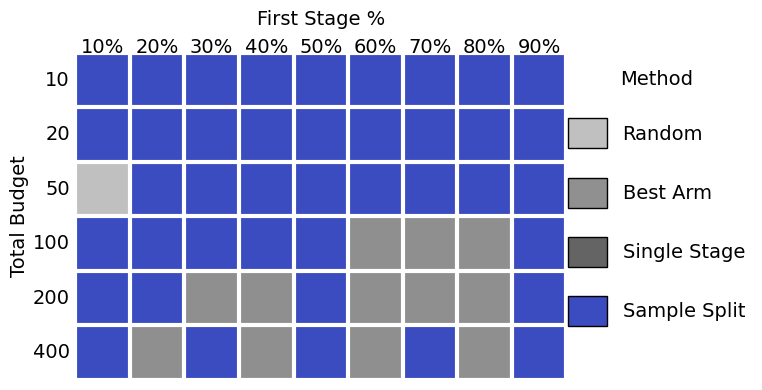

In [95]:
method_names = ['random','k_1','one_stage','sample_split']
nice_names = ["Random","Best Arm","Single Stage","Sample Split"]

baseline_params = {'sample_size': 500, 'number_arms': 10}
dataset = "baseline"
max_pulls_per_arm = [10,20,50,100,200,400]
fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

all_methods = [["" for i in range(len(fractions))] for j in range(len(max_pulls_per_arm))]

for i in range(len(max_pulls_per_arm)):
    for j in range(len(fractions)):
        baseline_params['sample_size'] = max_pulls_per_arm[i]*10
        baseline_params['first_stage_size'] = int(fractions[j]*max_pulls_per_arm[i]*10)

        results = get_results_matching_parameters(dataset,"",baseline_params)
        results = aggregate_normalize_data(results,baseline='one_stage')
        results_by_method = [results[k][0] for k in method_names]
        best_method = np.argmax(results_by_method)
        all_methods[i][j] = best_method


# Example matrix of size n x m
n = len(max_pulls_per_arm)
m = len(fractions)

# Create a random matrix for demonstration
data_matrix = all_methods

# Define color mapping for your heatmap
colors = [colors_by_method[m] for m in method_names]
labels = nice_names
cmap = mcolors.ListedColormap(colors)
bounds = list(range(len(labels))) 
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(16, 4))

# Plot the heatmap with a border separating each cell
heatmap = ax.imshow(data_matrix, cmap=cmap, norm=norm)

# Add gridlines for borders around the cells
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

# Enable minor ticks (for gridlines without tick marks)
ax.set_xticks(np.arange(-.5, m, 1), minor=True)
ax.set_yticks(np.arange(-.5, n, 1), minor=True)

# Remove tick marks and axis labels
ax.set_xticks([])
ax.set_yticks([])

ax.tick_params(which="minor", size=0)  # Turn off tick marks
ax.tick_params(axis='both', which='both', length=0)  # Remove tick lines

ax.set_xlabel("First Stage %",labelpad=20)
ax.set_ylabel("Total Budget",labelpad=30)
ax.xaxis.set_label_position('top')

for spine in ax.spines.values():
    spine.set_visible(False)

# Add row and column labels (now with black text on lighter grey background)
row_labels = ["10","20","50","100","200","400"]
column_labels = ["10%","20%","30%","40%","50%","60%","70%","80%","90%"]

# Set the labels with black text and lighter grey background
label_background = '#d3d3d3'  # A light grey
for i in range(len(row_labels)):
    ax.text(-0.6, i, row_labels[i], va='center', ha='right', color='black', fontsize=14,)
    
for i in range(len(column_labels)):
    ax.text(i, -0.6, column_labels[i], va='center', ha='center', color='black', fontsize=14)

# Create a custom legend to map each color to its label
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=labels[i]) for i in range(len(colors))]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1), ncol=1, title='Method', frameon=False,handleheight=2, handlelength=2, labelspacing=1.5,title_fontsize=14)

plt.tight_layout()
plt.show()
fig.savefig("../../results/figures/compare_one_stage.pdf",dpi=300, bbox_inches='tight')

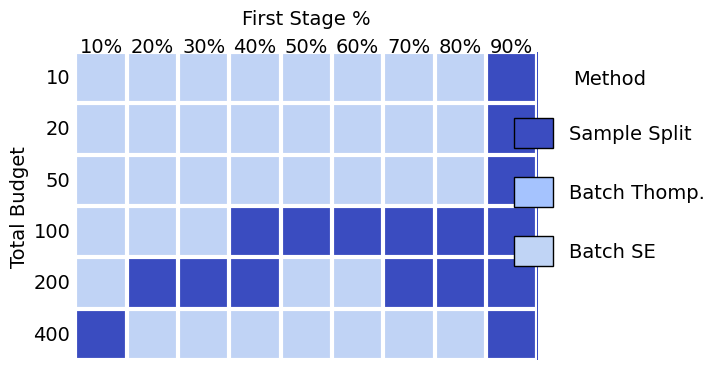

In [ ]:
method_names = ['sample_split','two_stage_thompson','two_stage_successive_elimination']
nice_names = ["Sample Split","Batch Thomp.","Batch SE"]
width = 0.1

baseline_params = {'sample_size': 500, 'number_arms': 10}
dataset = "baseline"
max_pulls_per_arm = [10,20,50,100,200,400]
fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

all_methods = [["" for i in range(len(fractions))] for j in range(len(max_pulls_per_arm))]

for i in range(len(max_pulls_per_arm)):
    for j in range(len(fractions)):
        baseline_params['sample_size'] = max_pulls_per_arm[i]*10
        baseline_params['first_stage_size'] = int(fractions[j]*max_pulls_per_arm[i]*10)

        results = get_results_matching_parameters(dataset,"",baseline_params)
        results = aggregate_normalize_data(results,baseline='one_stage')
        results_by_method = [results[k][0] for k in method_names]
        best_method = np.argmax(results_by_method)
        all_methods[i][j] = best_method



# Example matrix of size n x m
n = len(max_pulls_per_arm)
m = len(fractions)

# Create a random matrix for demonstration
data_matrix = all_methods

# Define color mapping for your heatmap
colors = [colors_by_method[m] for m in method_names]
labels = nice_names
cmap = mcolors.ListedColormap(colors)
bounds = list(range(len(labels))) 
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(16, 4))

# Plot the heatmap with a border separating each cell
heatmap = ax.imshow(data_matrix, cmap=cmap, norm=norm)

# Add gridlines for borders around the cells
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

# Enable minor ticks (for gridlines without tick marks)
ax.set_xticks(np.arange(-.5, m, 1), minor=True)
ax.set_yticks(np.arange(-.5, n, 1), minor=True)

# Remove tick marks and axis labels
ax.set_xticks([])
ax.set_yticks([])

ax.tick_params(which="minor", size=0)  # Turn off tick marks
ax.tick_params(axis='both', which='both', length=0)  # Remove tick lines

for spine in ax.spines.values():
    spine.set_visible(False)

# Add row and column labels (now with black text on lighter grey background)
row_labels = ["10","20","50","100","200","400"]
column_labels = ["10%","20%","30%","40%","50%","60%","70%","80%","90%"]

# Set the labels with black text and lighter grey background
label_background = '#d3d3d3'  # A light grey
for i in range(len(row_labels)):
    ax.text(-0.6, i, row_labels[i], va='center', ha='right', color='black', fontsize=14,)
    
for i in range(len(column_labels)):
    ax.text(i, -0.6, column_labels[i], va='center', ha='center', color='black', fontsize=14)

ax.set_xlabel("First Stage %",labelpad=20)
ax.set_ylabel("Total Budget",labelpad=30)
ax.xaxis.set_label_position('top')



# Create a custom legend to map each color to its label
legend_elements = [Patch(facecolor=colors[i], edgecolor='black', label=labels[i]) for i in range(len(colors))]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1), ncol=1, title='Method', frameon=False,handleheight=2, handlelength=2, labelspacing=1.5,title_fontsize=14)

fig.savefig("../../results/figures/compare_two_stage.pdf",dpi=300, bbox_inches='tight')

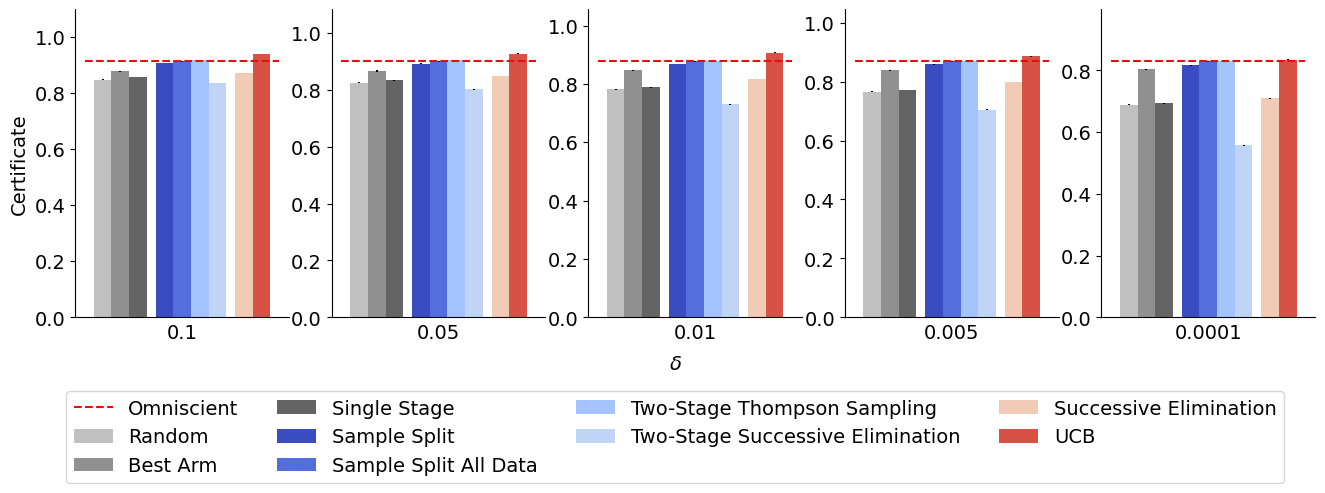

<Figure size 700x400 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(16, 4))
method_names = ['random','k_1','one_stage','sample_split','sample_split_total','two_stage_thompson','two_stage_successive_elimination','successive_elimination','ucb','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Sample Split All Data","Two-Stage Thompson Sampling","Two-Stage Successive Elimination","Successive Elimination","UCB","Omniscient"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'sample_size': 500, 'number_arms': 10}
dataset = "vary_delta"
delta_values = [0.1,0.05,0.01,0.005,0.0001]
delta_strings = [str(i) for i in delta_values]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'sample_split' or method_names[i] == 'successive_elimination':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(delta_values)):
    baseline_params['delta'] = delta_values[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random']['certificate'])
    results = aggregate_normalize_data(results,baseline='one_stage')
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)

        if m == 'omniscient':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(delta_values[i],fontsize=14)
        

axs[0].set_ylabel("Certificate",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.supxlabel("$\delta$",fontsize=14,x=0.5,y=-0.03)
fig.savefig("../../results/figures/delta_values.pdf",dpi=300, bbox_inches='tight')


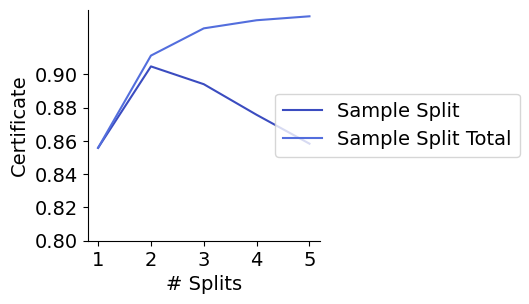

In [ ]:
plt.figure(figsize=(3,3))
method_names = ['one_stage','sample_split','sample_split_3','sample_split_4','sample_split_5']
width = 0.1
baseline_params = {'sample_size': 500, 'number_arms': 10, 'first_stage_size': 250}
dataset = "baseline"
results = get_results_matching_parameters(dataset,"",baseline_params)
results = aggregate_normalize_data(results,baseline='one_stage')

y_values = [results[m][0] for m in method_names]

plt.plot([1,2,3,4,5],y_values,color=colors_by_method['sample_split'],label="Sample Split")
plt.xticks([1,2,3,4,5])

method_names = ['one_stage','sample_split_total','sample_split_total_3','sample_split_total_4','sample_split_total_5']
y_values = [results[m][0] for m in method_names]

plt.plot([1,2,3,4,5],y_values,color=colors_by_method['sample_split_total'],label="Sample Split Total")
plt.ylabel("Certificate")
plt.xlabel("# Splits")
plt.yticks([0.8,0.82,0.84,0.86,0.88,0.9])
plt.legend(loc='center right',bbox_to_anchor=(1.9, 0.5))

plt.savefig("../../results/figures/multi_stage.pdf",dpi=300, bbox_inches='tight')


one_stage 1.0666153311978515
sample_split 0.9829562651246856
prior 1.0
two_stage_successive_elimination 1.0951636717058293
two_stage_thompson 0.9920722439968492
successive_elimination 1.0332080309586111
ucb 0.9315756220769423
omniscient 0.970349929286807
one_stage 1.1085476010851156
sample_split 1.1309686955737623
prior 1.0
two_stage_successive_elimination 1.1420033875853972
two_stage_thompson 1.0738130830235968
successive_elimination 1.1322032581033057
ucb 1.0075033901108577
omniscient 1.0474262574018947
one_stage 1.2396707953901054
sample_split 1.1345157105108137
prior 1.0
two_stage_successive_elimination 1.4387498295755448
two_stage_thompson 1.0798008132080386
successive_elimination 1.4947798999863076
ucb 1.18188537637203
omniscient 1.1047889307293428


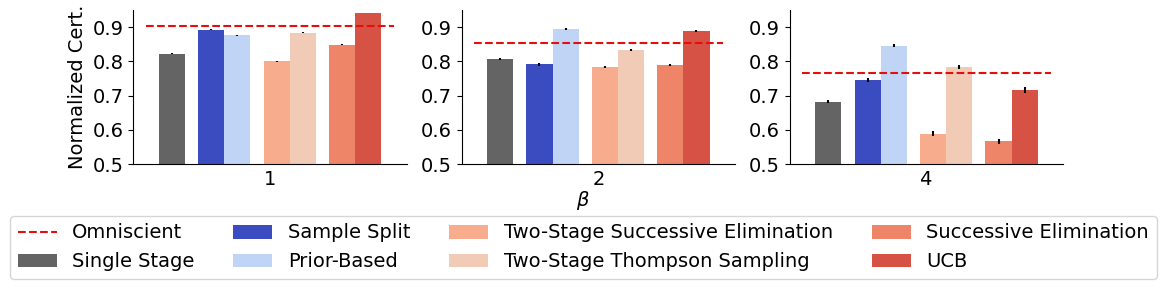

In [129]:
fig, axs = plt.subplots(1,3, figsize=(12, 2))
method_names = ['one_stage','sample_split', 'prior','two_stage_successive_elimination','two_stage_thompson','successive_elimination','ucb','omniscient']
nice_names = ["Single Stage","Sample Split","Prior-Based","Two-Stage Successive Elimination","Two-Stage Thompson Sampling","Successive Elimination","UCB","Omniscient"]
width = 0.1

baseline_params = {'arm_distribution': 'beta', 'alpha': 1, 'beta': 1}
dataset = "prior_data"

x_locations = [] 
beta = [1,2,4]
shift = 0
for i in range(len(method_names)):
    if method_names[i] == "sample_split" or method_names[i] == 'two_stage_successive_elimination' or method_names[i] == 'successive_elimination':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(first_stage_sizes)):
    baseline_params['beta'] = beta[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random']['certificate'])
    results = aggregate_normalize_data(results,normalized='max')
    for k,m in enumerate(method_names):
        print(m,results['prior'][0]/results[m][0])

        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)
        
    
        
        if m == 'omniscient':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.5,0.95])
        axs[i].set_xlabel(beta[i],fontsize=14)
        axs[i].set_yticks([0.5,0.6,0.7,0.8,0.9])

axs[0].set_ylabel("Normalized Cert.",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.1),fontsize=14)

fig.supxlabel("$\\beta$",fontsize=14,x=0.5,y=-0.13)
fig.savefig("../../results/figures/prior.pdf",dpi=300, bbox_inches='tight')


0.05 15
0.1 15
0.2 15


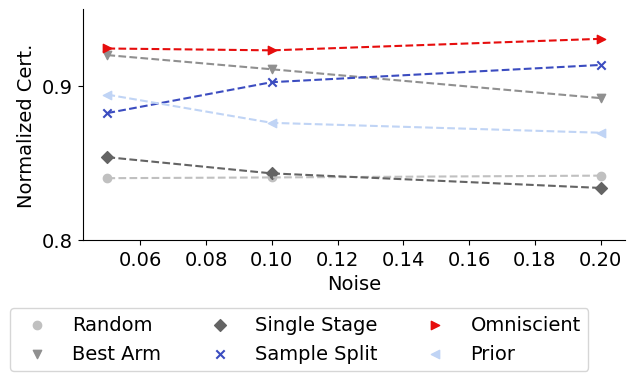

In [83]:
plt.figure(figsize=(7,3))
method_names = ['random','k_1','one_stage','sample_split','omniscient','prior']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Omniscient","Prior"]

diff_mean_1 = [0.05,0.1,0.2]
baseline_params = {'arm_distribution': 'beta_misspecified', 'alpha': 2, 'beta': 2, 'diff_std_1': 0.1}

plots_by_method = {}
for m in method_names:
    plots_by_method[m] = []

for d in diff_mean_1:
    baseline_params['diff_mean_1'] = d
    dataset = "prior_data"
    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(d,len(results))
    results = aggregate_normalize_data(results,normalized='max')
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}'.format(method_name)][0])

for i,m in enumerate(method_names):
    zipped_values = zip(diff_mean_1,plots_by_method[m])
    zipped_values = [i for i in zipped_values if i[0] < 1.0]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    plt.plot(x, y,'--', color=colors_by_method[m])

plt.ylim([0.8,0.95])
plt.yticks([0.8,0.9])
plt.legend(fontsize=14,bbox_to_anchor=(0.95,-0.25),ncol=3)
plt.ylabel("Normalized Cert.")
plt.xlabel("Noise")
plt.savefig("../../results/figures/diff_mean_prior.pdf",dpi=300, bbox_inches='tight')




0.01 15
0.05 15
0.1 15
0.25 15


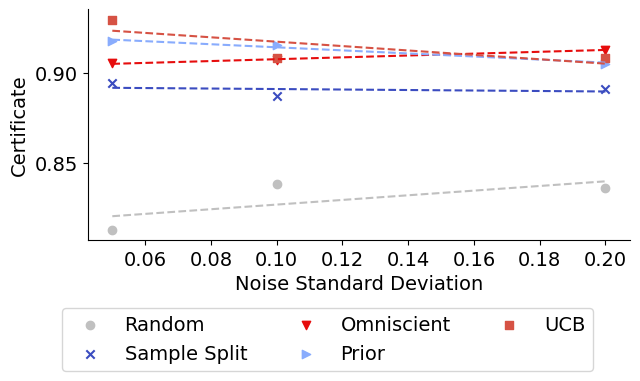

In [ ]:
plt.figure(figsize=(7,3))
method_names = ['random','sample_split','omniscient','prior','ucb']
nice_names = ["Random","Sample Split","Omniscient","Prior","UCB"]

diff_std_1 = [0.01,0.05,0.1,0.25]
baseline_params = {'arm_distribution': 'beta_misspecified', 'alpha': 2, 'beta': 2, 'diff_mean_1': 0}

plots_by_method = {}
for m in method_names:
    plots_by_method[m] = []

for d in diff_std_1:
    baseline_params['diff_std_1'] = d
    dataset = "prior_data"
    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(d,len(results))
    results = aggregate_normalize_data(results,baseline='one_stage')
    
    for method_name in method_names:
        plots_by_method[method_name].append(results['{}'.format(method_name)][0])

for i,m in enumerate(method_names):
    zipped_values = zip(diff_mean_1,plots_by_method[m])
    zipped_values = [i for i in zipped_values if i[0] < 1.0]
    zipped_values = sorted(zipped_values,key=lambda k: k[0])
    x,y = list(zip(*zipped_values))
    plt.scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
    
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    plt.plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])

# plt.ylim([0.6,0.75])
plt.legend(fontsize=14,bbox_to_anchor=(0.95,-0.25),ncol=3)
plt.ylabel("Certificate")
plt.xlabel("Noise Standard Deviation")
plt.savefig("../../results/figures/diff_std_prior.pdf",dpi=300, bbox_inches='tight')




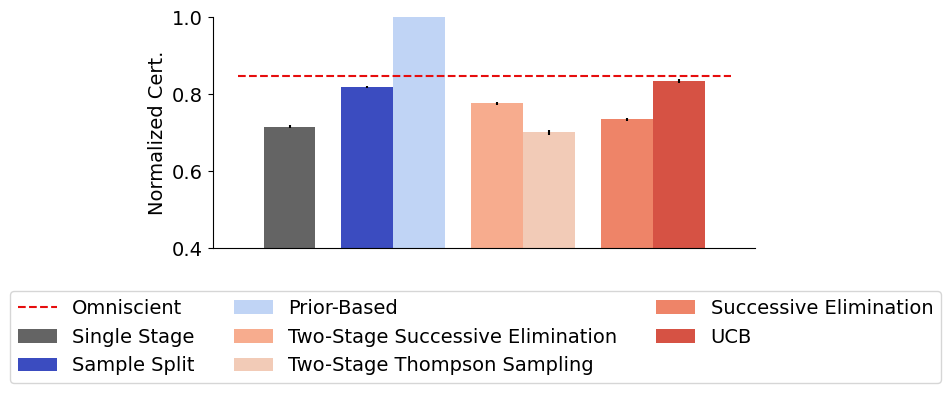

In [139]:
fig, axs = plt.subplots(1,1, figsize=(7, 3))
method_names = ['one_stage','sample_split', 'prior','two_stage_successive_elimination','two_stage_thompson','successive_elimination','ucb','omniscient']
nice_names = ["Single Stage","Sample Split","Prior-Based","Two-Stage Successive Elimination","Two-Stage Thompson Sampling","Successive Elimination","UCB","Omniscient"]
width = 0.1

baseline_params = {'arm_distribution': 'effect_size'}
dataset = "prior_data"
first_stage_sizes = [0.1]#,0.01,0.001]
first_stage_percent = [0.1]#,0.01,0.001]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == "sample_split" or method_names[i] == 'two_stage_successive_elimination' or method_names[i] == 'successive_elimination':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(first_stage_sizes)):
    baseline_params['delta'] = first_stage_sizes[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random']['certificate'])
    results = aggregate_normalize_data(results,normalized='max')
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)
        
    
        
        if m == 'omniscient':
            axs.hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs.bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs.set_xticks([])
        axs.tick_params(axis='both', which='major', labelsize=14)
        axs.set_ylim([0.4,1])
        axs.set_yticks([0.4,0.6,0.8,1])

axs.set_ylabel("Normalized Cert.",fontsize=14)

handles, labels = axs.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0),fontsize=14)

fig.savefig("../../results/figures/real_world.pdf",dpi=300, bbox_inches='tight')


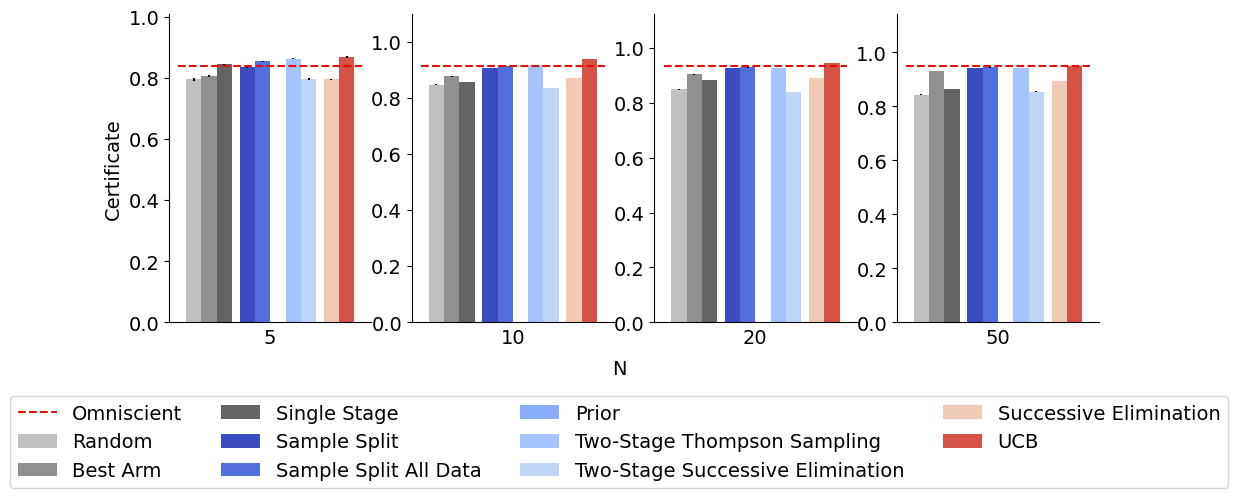

<Figure size 700x400 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','k_1','one_stage','sample_split','sample_split_total','prior','two_stage_thompson','two_stage_successive_elimination','successive_elimination','ucb','omniscient']
nice_names = ["Random","Best Arm","Single Stage","Sample Split","Sample Split All Data","Prior","Two-Stage Thompson Sampling","Two-Stage Successive Elimination","Successive Elimination","UCB","Omniscient"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'sample_size': 50, 'number_arms': 10, 'first_stage_size': 125}
dataset = "baseline"
number_arms = [5,10,20,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'sample_split' or method_names[i] == 'successive_elimination':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(number_arms)):
    baseline_params['number_arms'] = number_arms[i]
    baseline_params['sample_size'] = 50*number_arms[i]
    baseline_params['first_stage_size'] = int(50*number_arms[i]/2)
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['sample_split']['certificate'])
    results = aggregate_normalize_data(results,baseline='one_stage')
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}'.format(m) not in results:
            results['{}'.format(m)] = [0,0]
        score_by_n.append(results['{}'.format(m)][0])
        std_by_n.append(results['{}'.format(m)][1]/num_data**.5)

        if m == 'omniscient':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Omniscient',color=colors_by_method[m])
            max_val = results['{}'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(number_arms[i],fontsize=14)
        

axs[0].set_ylabel("Certificate",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.supxlabel("N",fontsize=14,x=0.5,y=-0.03)
fig.savefig("../../results/figures/number_arms.pdf",dpi=300, bbox_inches='tight')


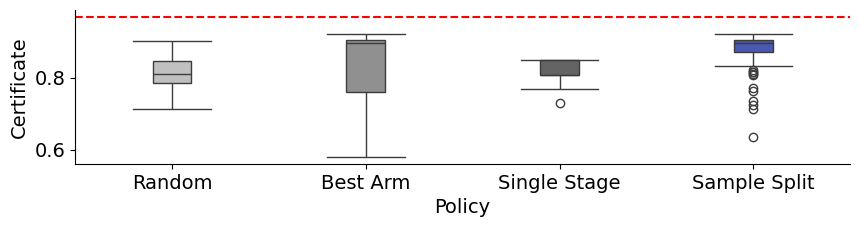

In [ ]:
plt.figure(figsize=(10,2))
method_names = ['random','k_1','one_stage','sample_split']
nice_names = ["Random","Best Arm","Single Stage","Sample Split"]

baseline_params = {'sample_size': 500, 'number_arms': 10, 'first_stage_size': 250}
dataset = "baseline"

results = get_results_matching_parameters(dataset,"",baseline_params)
true_value = results[0]['parameters']['true_value']
our_values = [results[0][m]['certificate'] for m in method_names]
sns.boxplot(data=our_values,palette=[colors_by_method[m] for m in method_names],widths=0.2)

# Set the x-ticks and labels
plt.xticks(ticks=range(len(nice_names)), labels=nice_names)

# Add a dashed line for the true value
plt.axhline(y=true_value, color='r', linestyle='--')
# Adding labels and title
plt.ylabel('Certificate')
plt.xlabel("Policy")

plt.savefig("../../results/figures/box_plot.pdf",dpi=300, bbox_inches='tight')

